In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from typing import Generator

In [3]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, max_diff: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            if timeX - timeY > max_diff:
                tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
                X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
        if timeY - timeX > max_diff:
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

In [4]:
df_X1 = load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx')

In [5]:
def vibr_quantile(df: pd.DataFrame) -> pd.DataFrame:
    datas = df.copy()  # Make a copy of the dataframe
    
    for column in datas.columns[2:]:
        # Calculate the upper and lower limits with adjusted threshold (e.g., 3 instead of 1.5)
        Q1 = datas[column].quantile(0.25)
        Q3 = datas[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        
        # Create arrays of Boolean values indicating the outlier rows
        upper_array = np.where(datas[column] > upper)[0]
        lower_array = np.where(datas[column] < lower)[0]
        
        # Remove the outliers
        datas = datas[~datas.index.isin(upper_array)]
        datas = datas[~datas.index.isin(lower_array)]
    
    # Reset the index of the dataframe
    datas.reset_index(drop=True, inplace=True)
    
    return datas

In [11]:
import pandas as pd
import numpy as np


def filter_outliers(df: pd.DataFrame, chunk_size: int, threshold: float) -> pd.DataFrame:
    filtered_data = pd.DataFrame()
    
    for column in df.columns:
        # Разделяем столбец DataFrame на части определенного размера
        chunks = [df[column].iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        # Вычисляем среднее значение для каждой части
        averages = [chunk.mean() for chunk in chunks]
        averages = pd.Series(averages)
        
        # Определение выбросов на основе заданного порога
        lower_bound = np.percentile(averages, threshold)
        upper_bound = np.percentile(averages, 100 - threshold)
        
        # Фильтрация выбросов
        filtered_chunks = [chunks[i] for i, avg in averages.items() if lower_bound <= avg <= upper_bound]
        
        # Замена столбца на отфильтрованные данные
        filtered_column = pd.concat(filtered_chunks, ignore_index=True)
        
        # Удаление пустых ячеек
        filtered_column.dropna(inplace=True)
        
        # Обновление нумерации
        filtered_column.reset_index(drop=True, inplace=True)
        
        filtered_data[column] = filtered_column
    
    return filtered_data


In [17]:
filtered_df = filter_outliers(df_X1,10,10)
print(filtered_df)

       Расход бензина ККР на установку  Расход нафты ККР на установку  \
0                                95.63                           0.15   
1                                95.98                           0.01   
2                                95.60                           0.00   
3                                95.72                           0.00   
4                                95.53                           0.00   
...                                ...                            ...   
10304                           103.80                           0.00   
10305                           103.66                           0.00   
10306                           103.14                           0.00   
10307                           103.68                           0.00   
10308                           101.99                           0.00   

       Расход бензина на рециркуляцию от Е-1205  \
0                                           0.0   
1                    

In [18]:
import sys

sys.path.append("...")

import Essentials

In [19]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from IPython.display import display
import matplotlib.dates as mdates

In [20]:
def parameter_vis(df):
    num_of_columns = len(df.columns)
    df.set_index('DateTime', inplace = True)
    for i in range(num_of_columns - 1):
        column_data = df.iloc[:, i]
        column_data.plot(y = df.iloc[:, i].name, marker = 'o', linestyle='', markersize=2, linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tick_params(axis='x', labelsize=6)
        plt.title(f'График {df.iloc[:, i].name}')  
        plt.show()

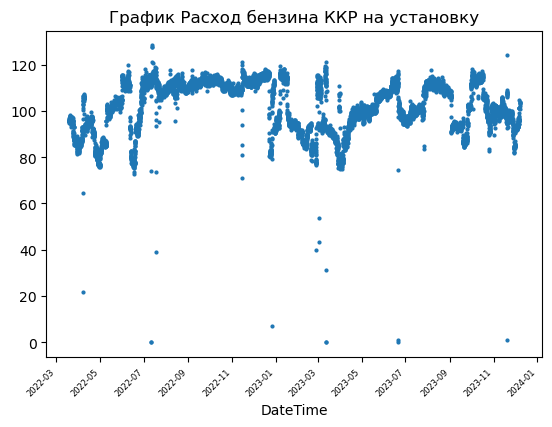

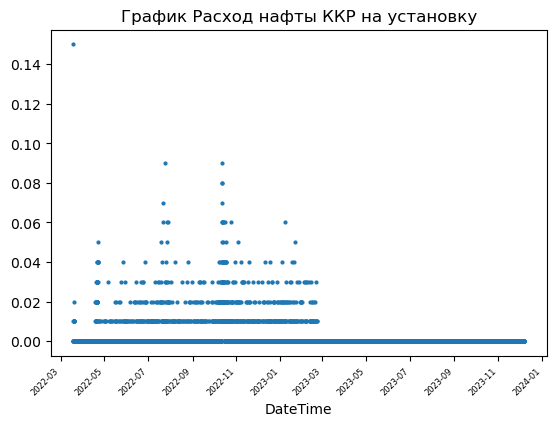

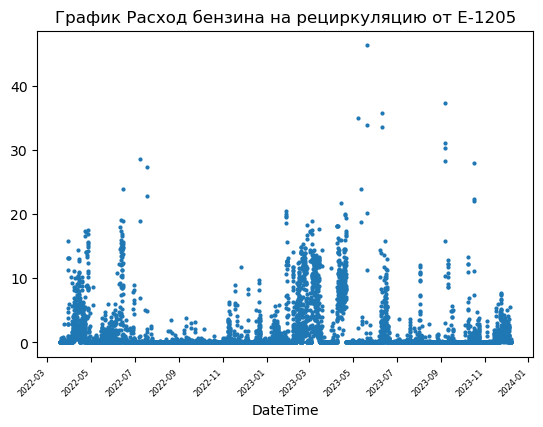

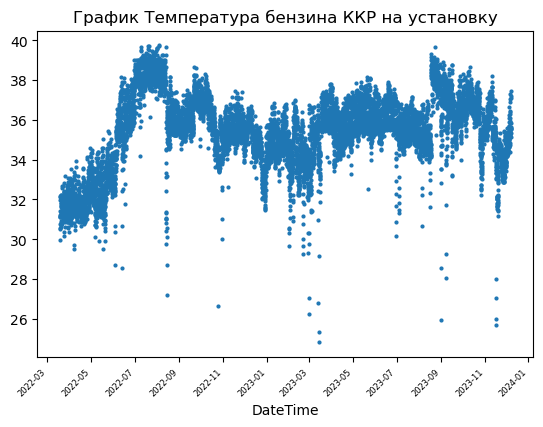

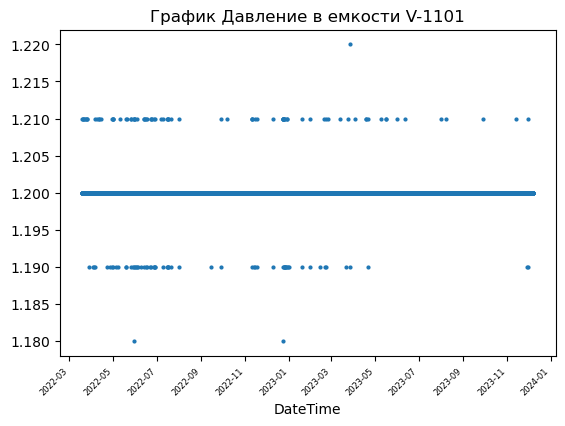

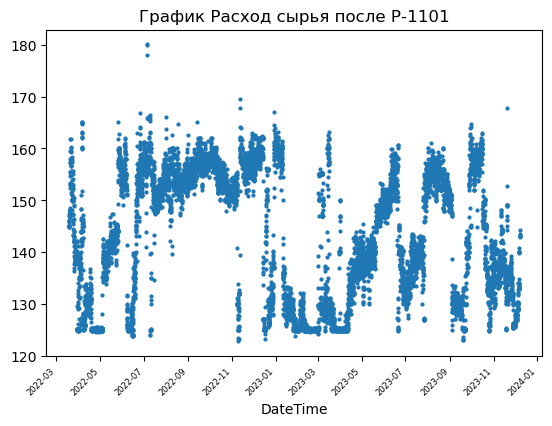

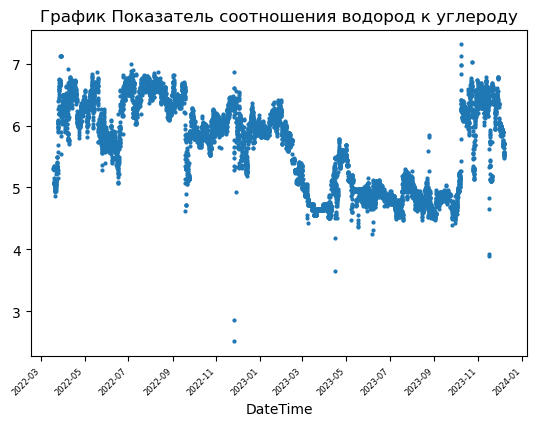

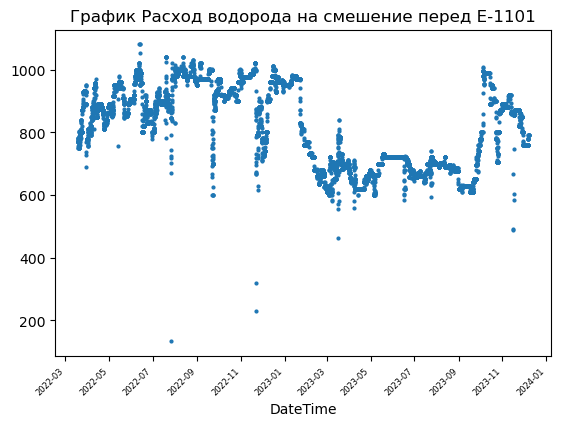

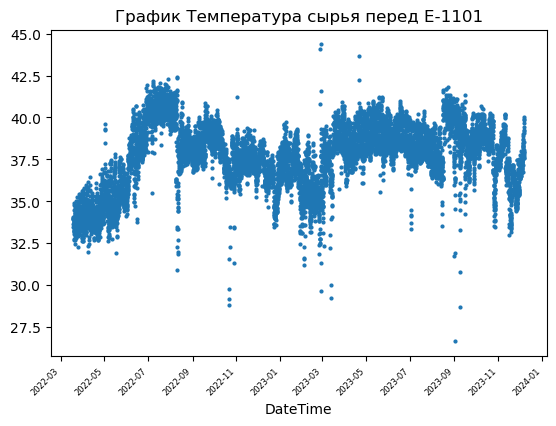

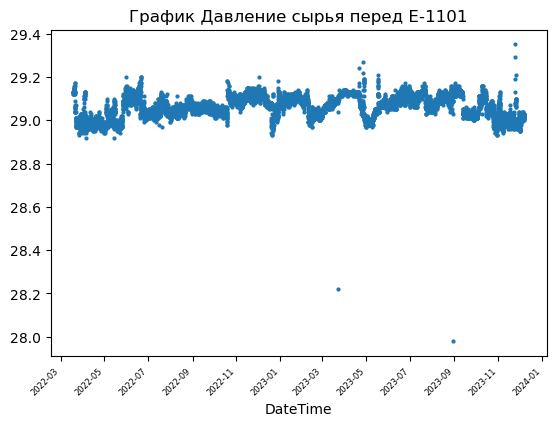

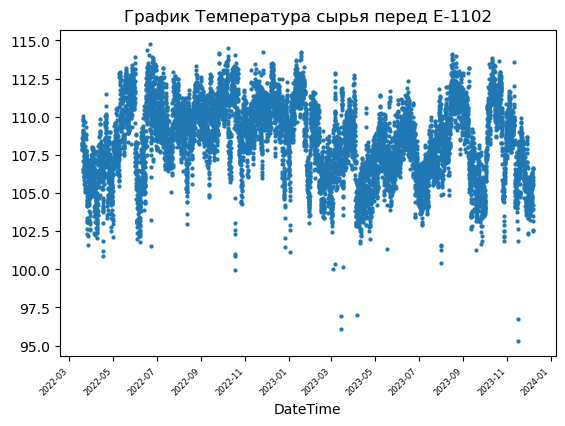

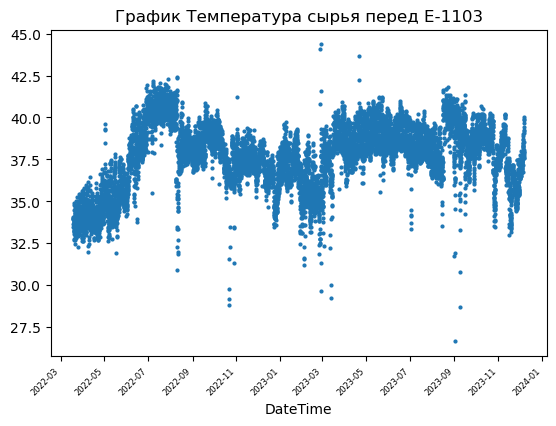

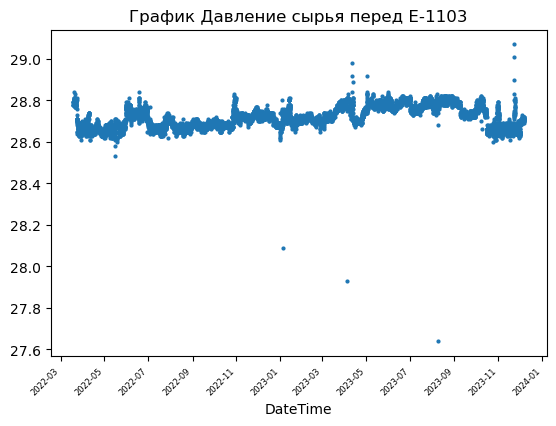

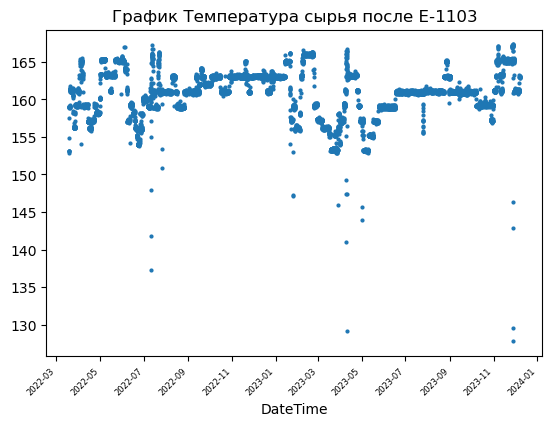

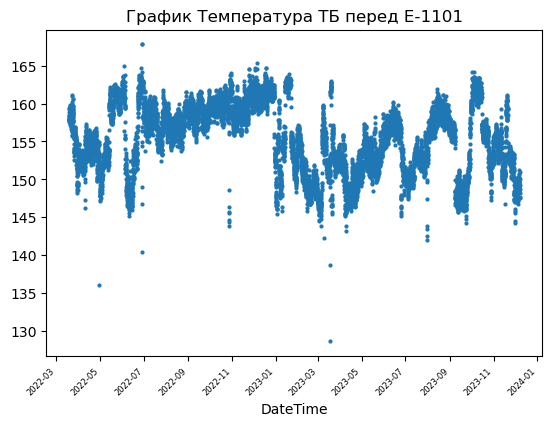

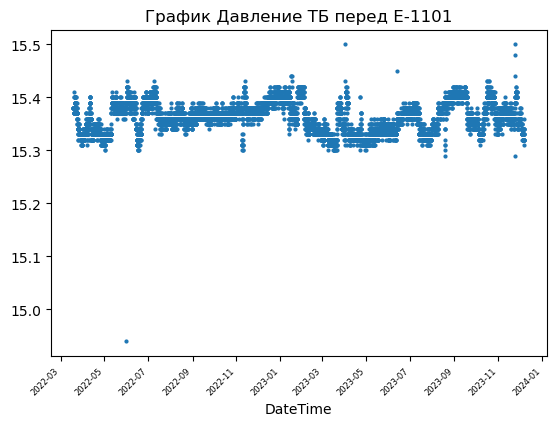

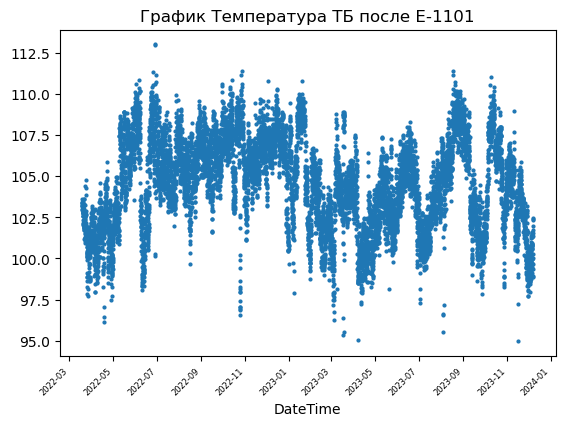

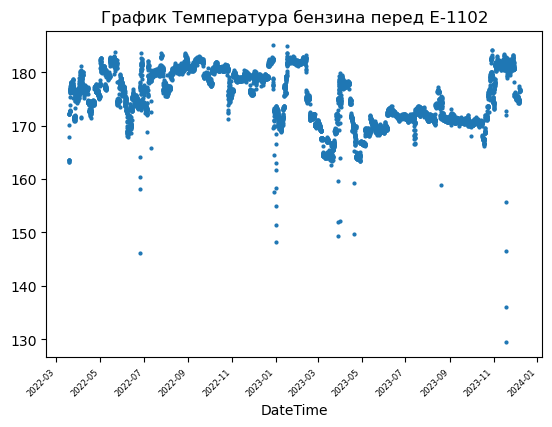

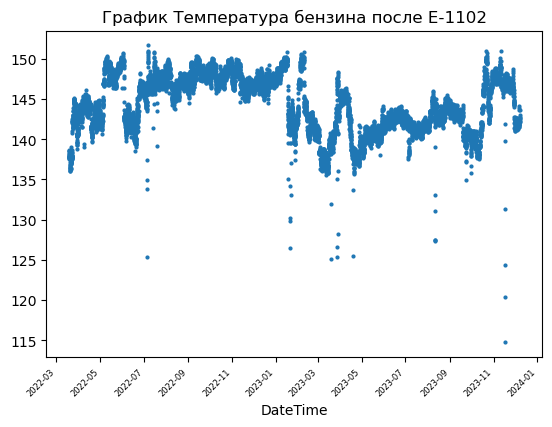

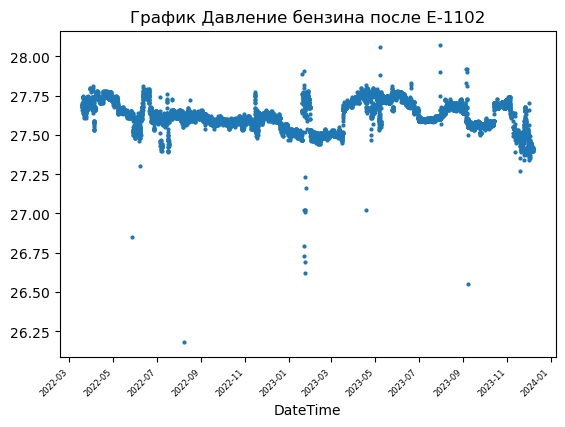

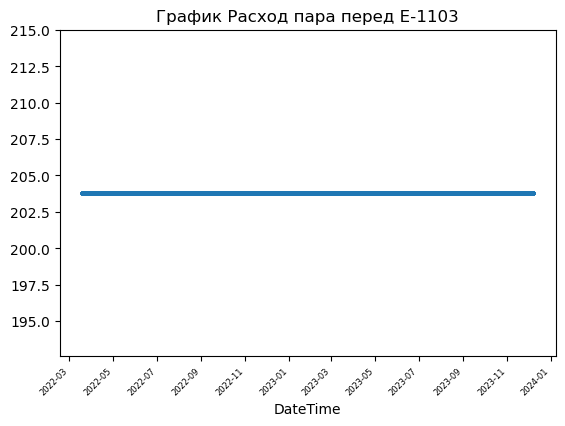

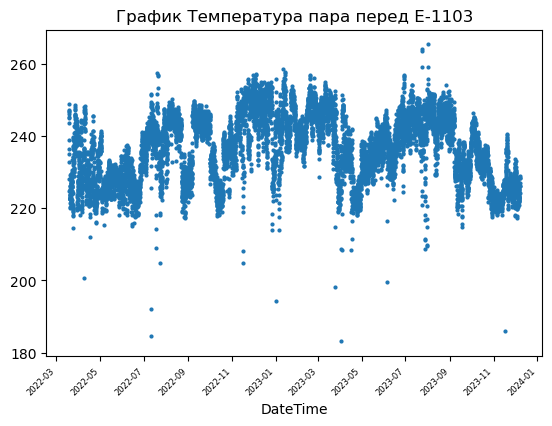

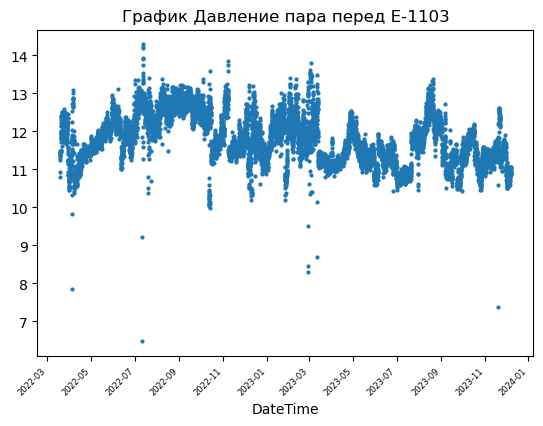

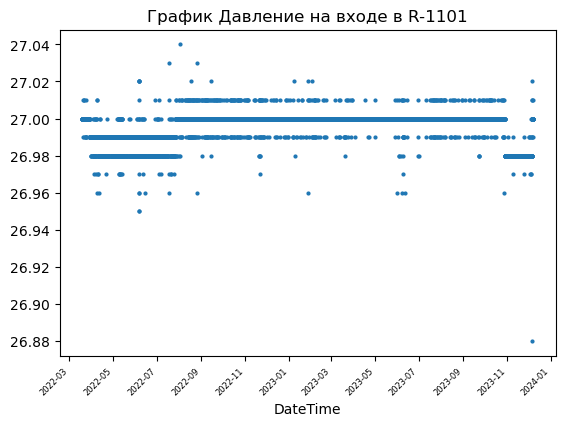

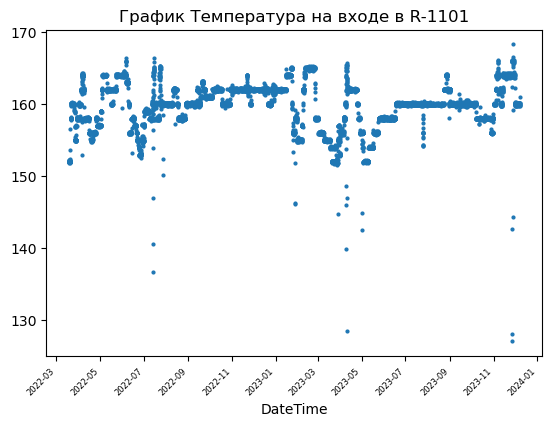

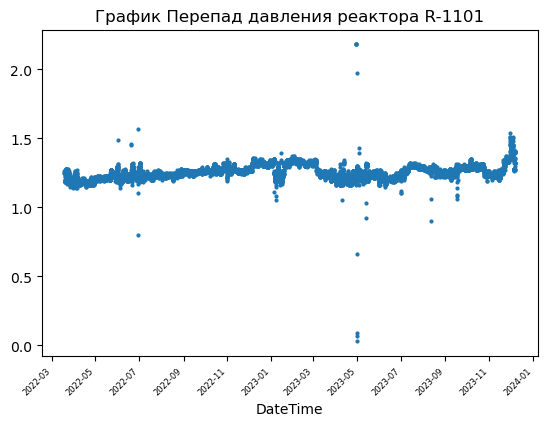

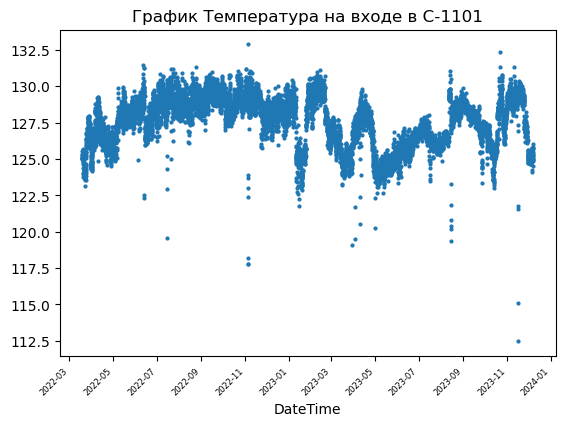

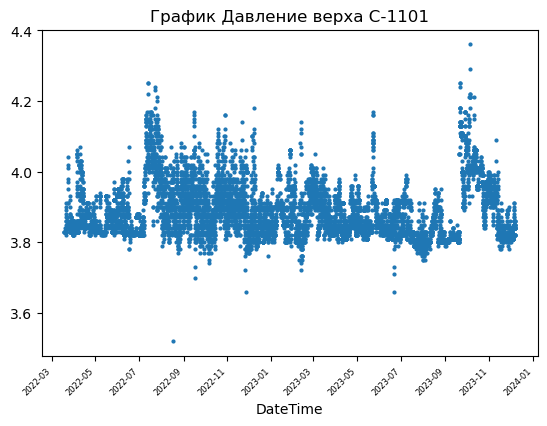

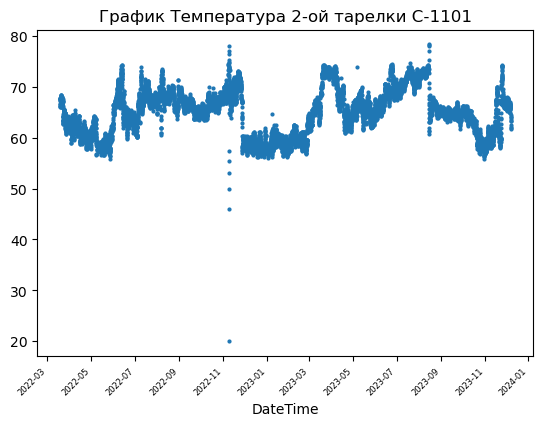

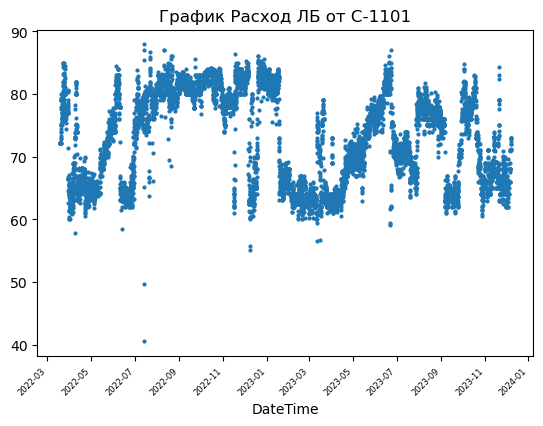

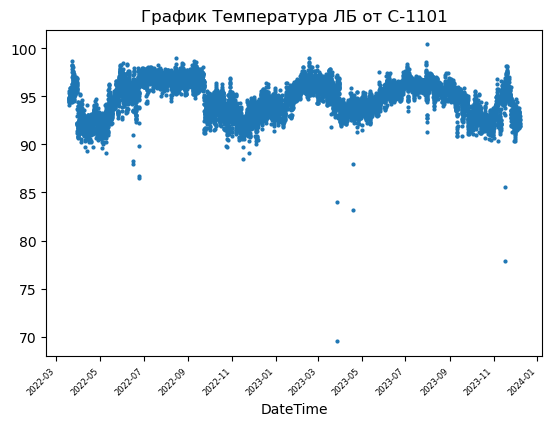

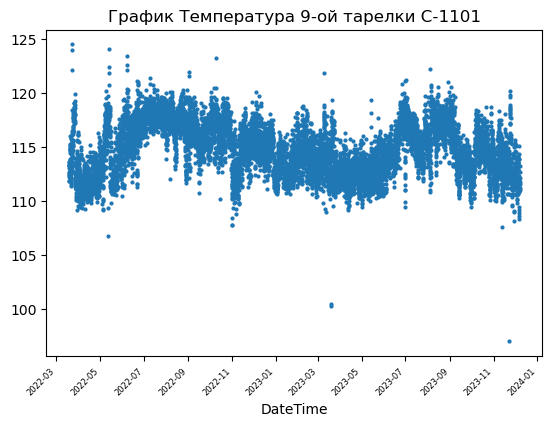

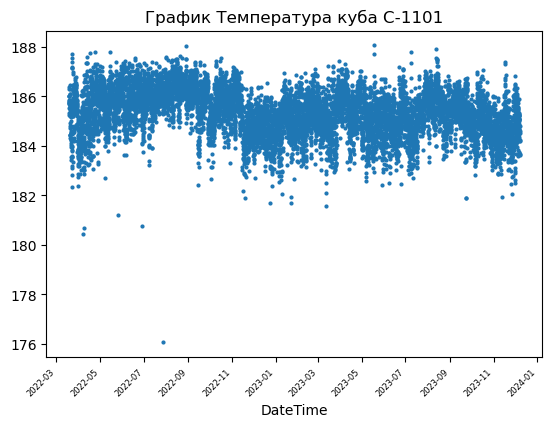

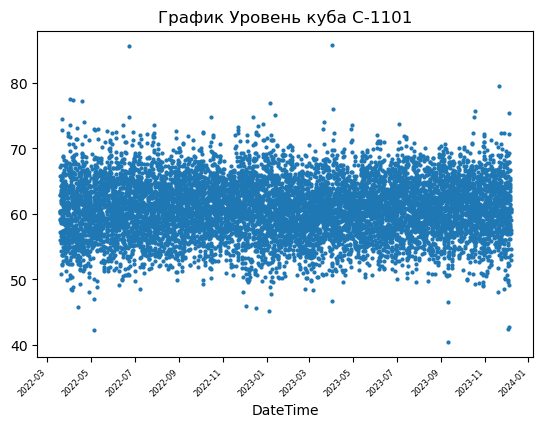

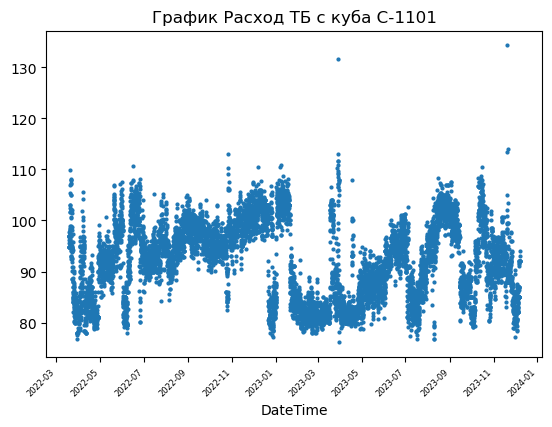

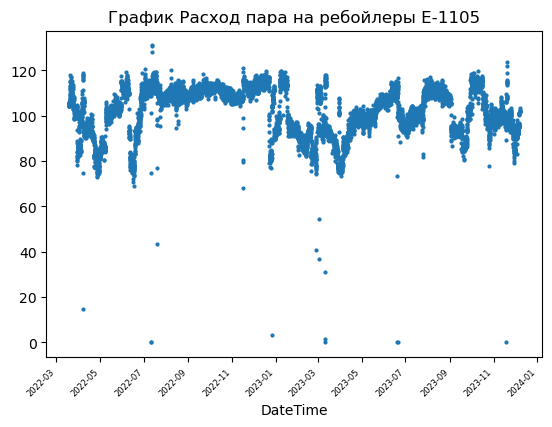

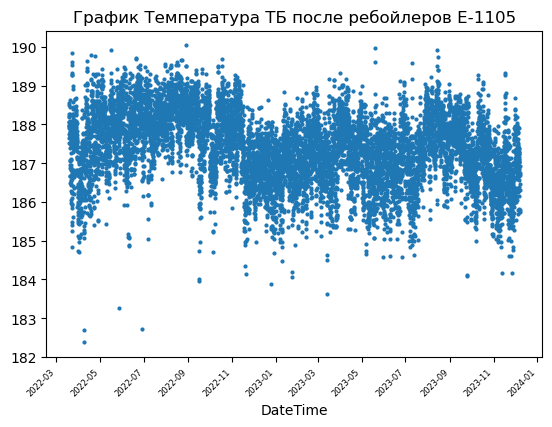

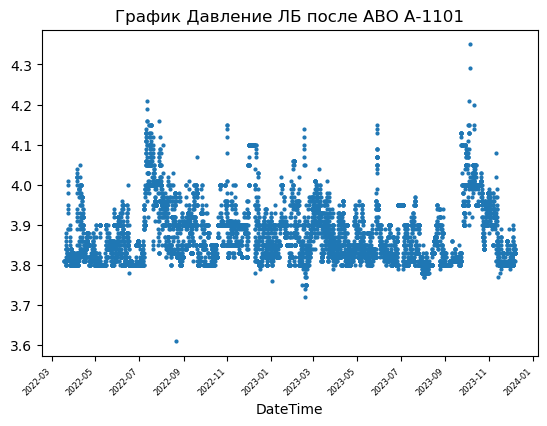

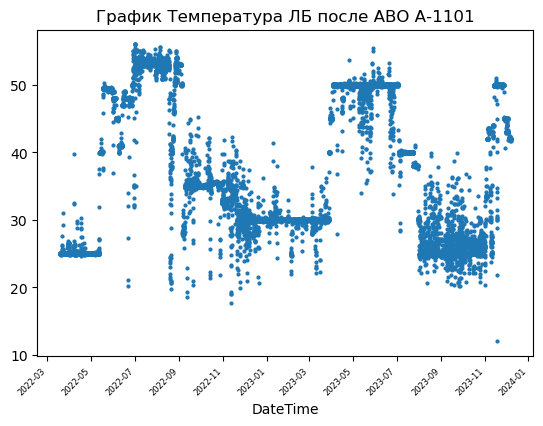

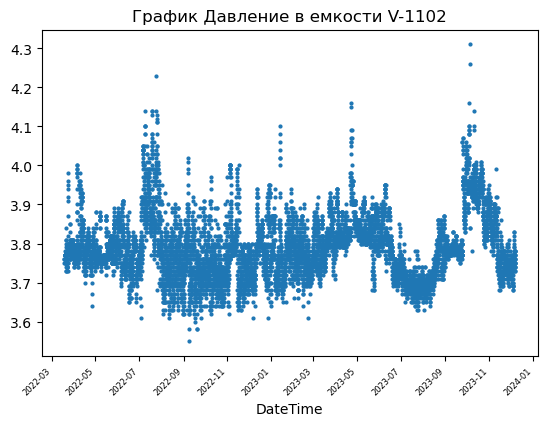

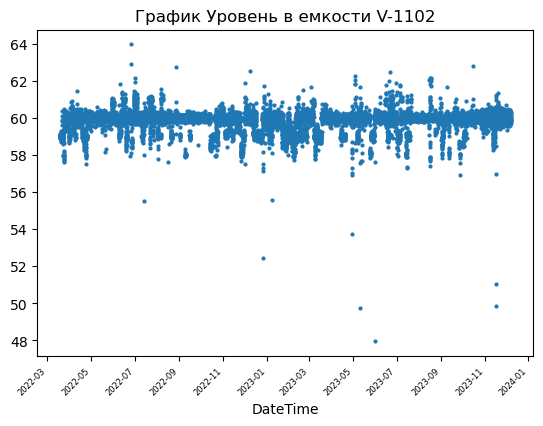

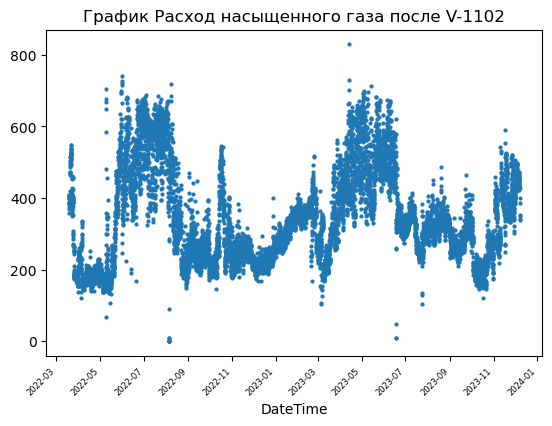

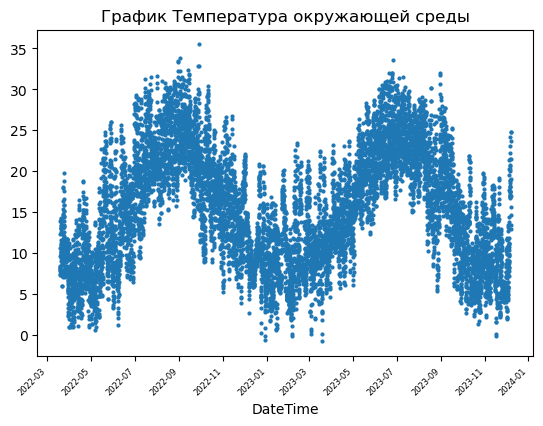

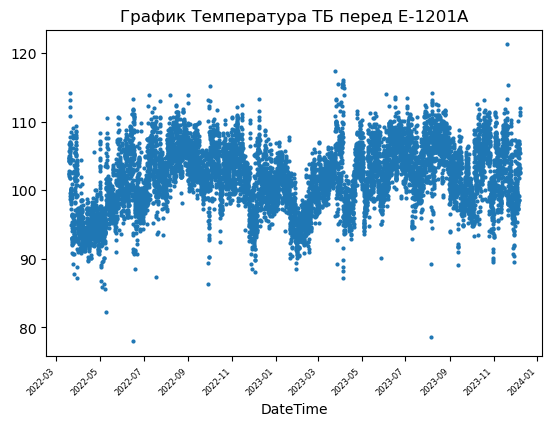

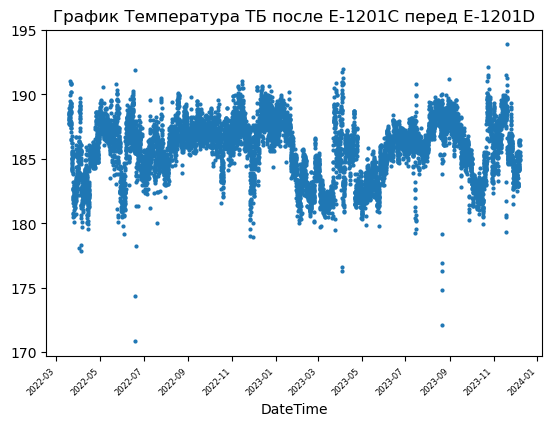

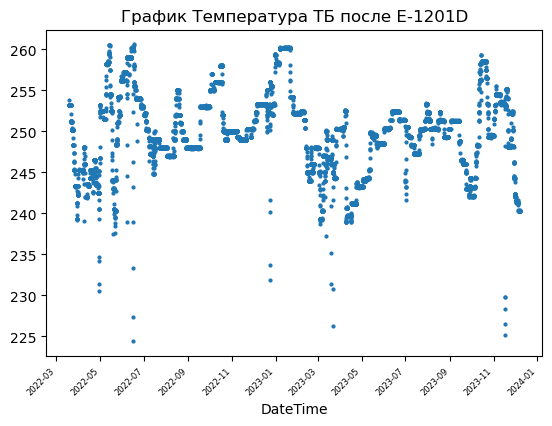

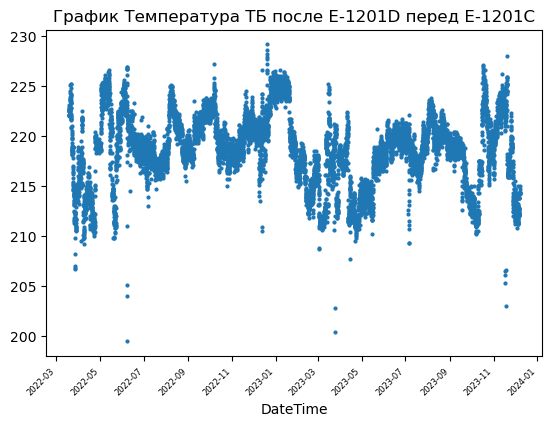

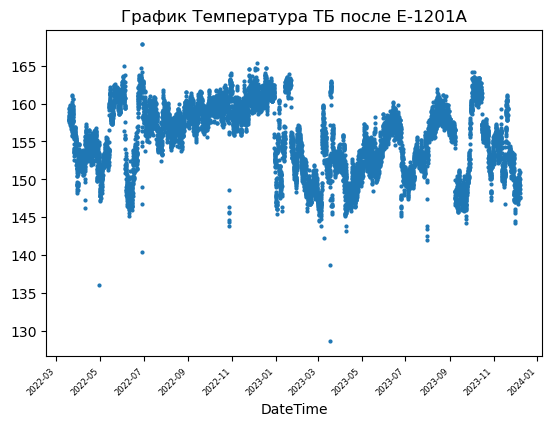

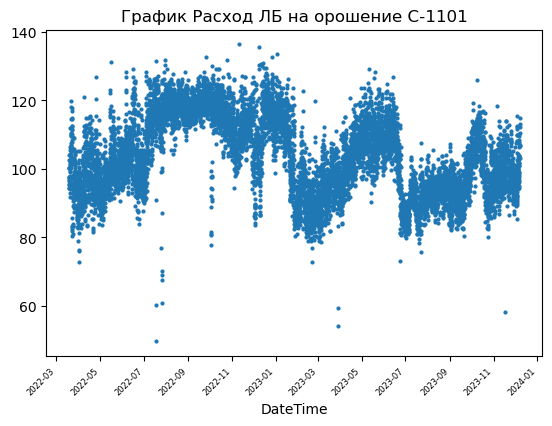

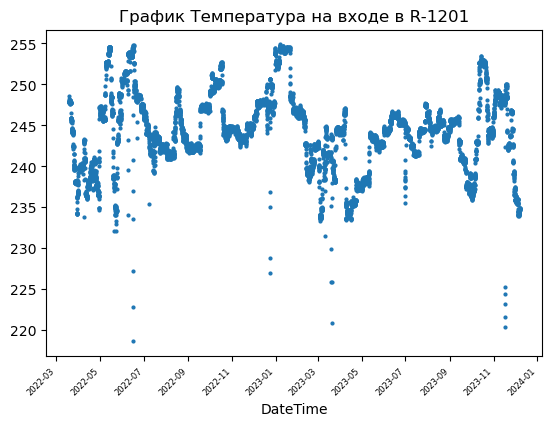

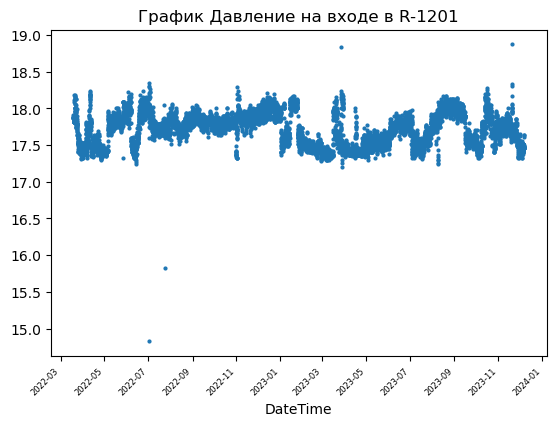

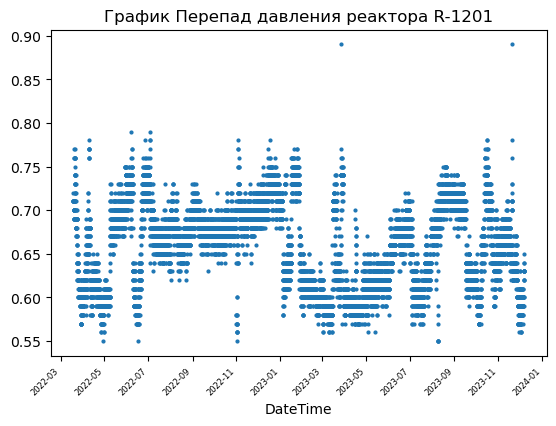

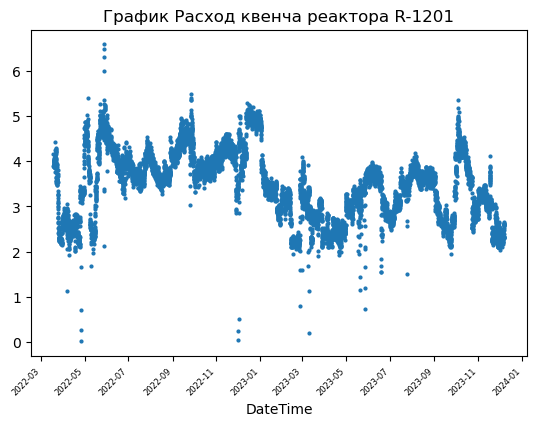

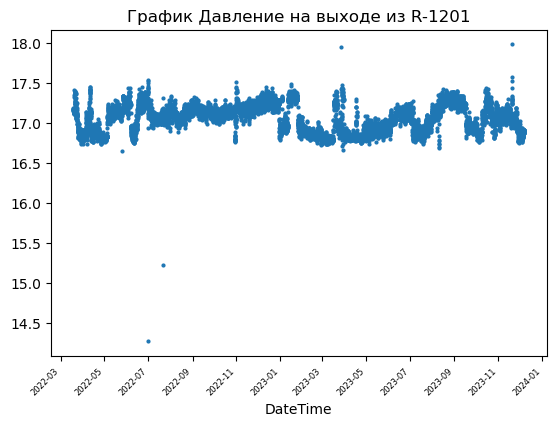

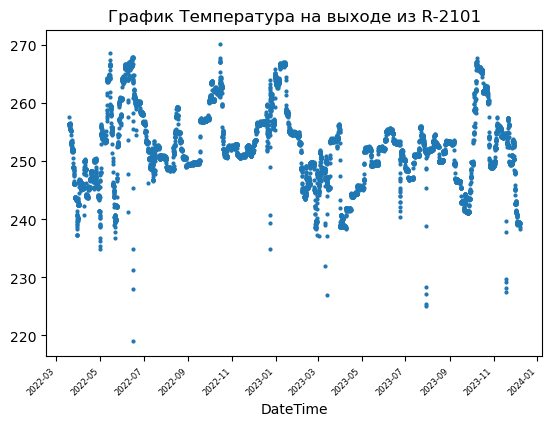

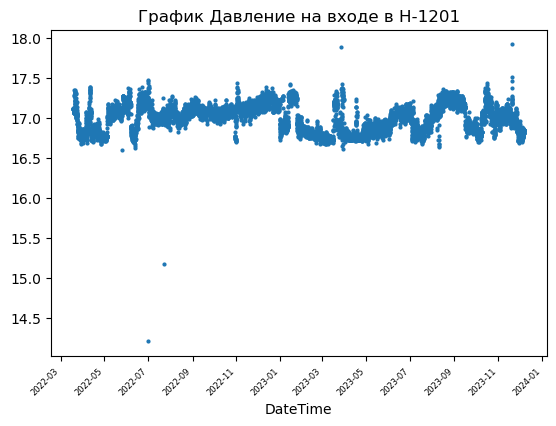

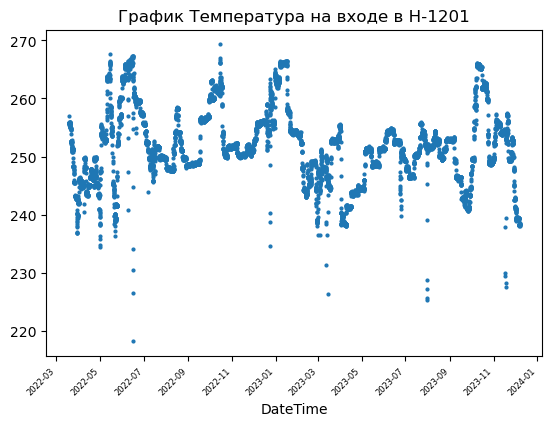

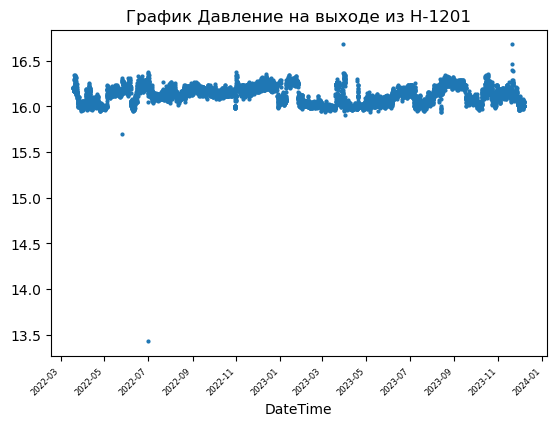

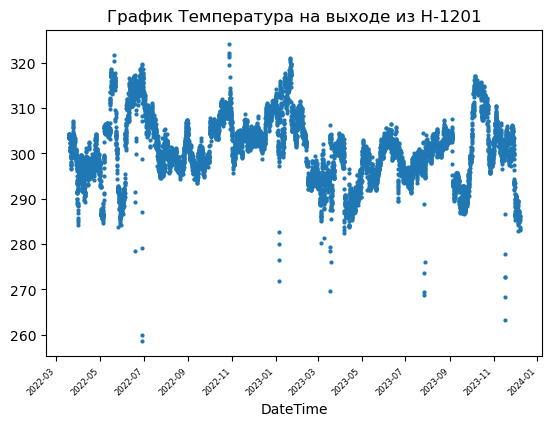

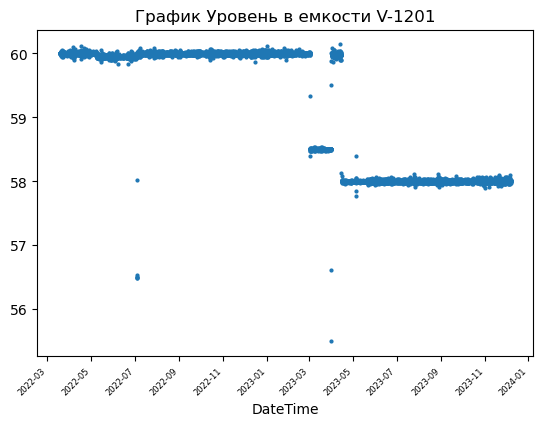

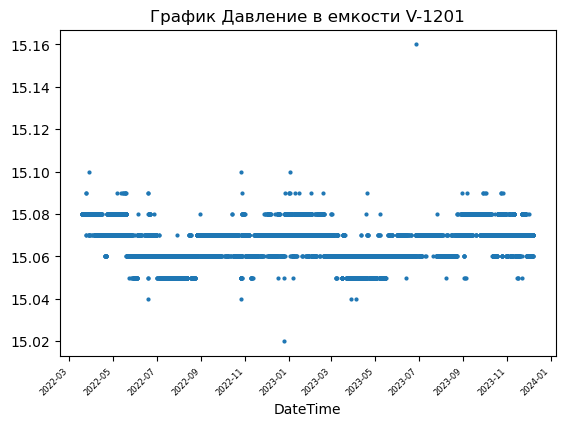

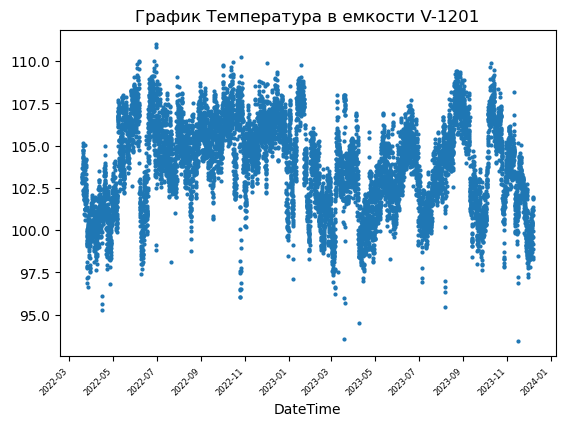

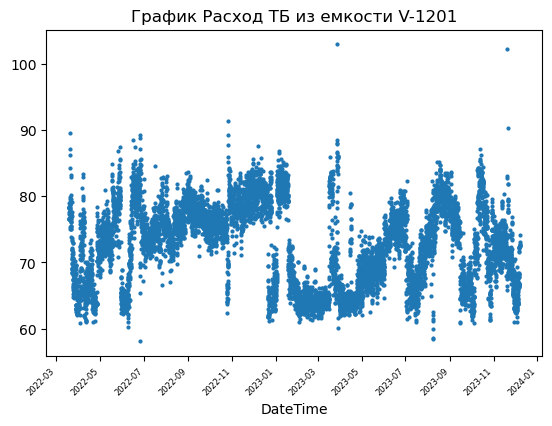

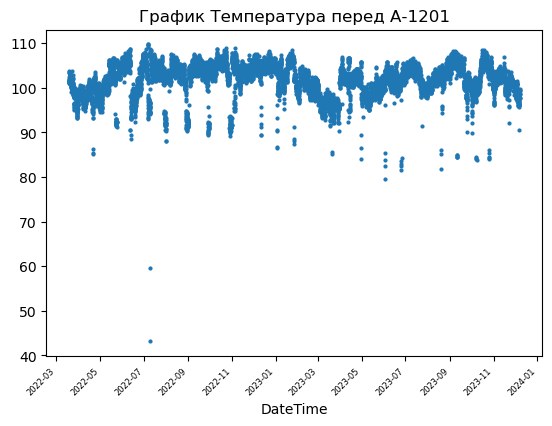

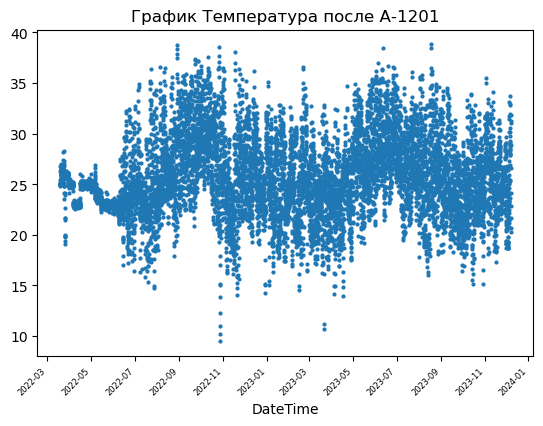

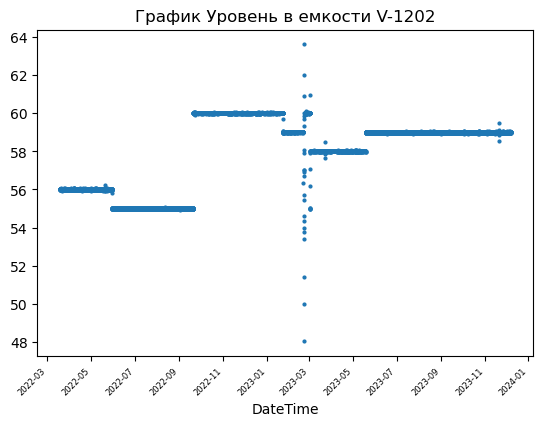

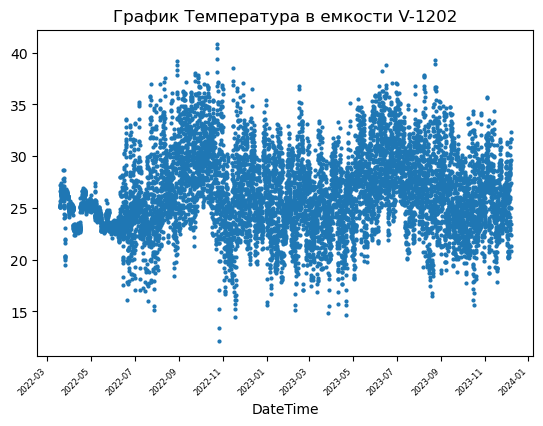

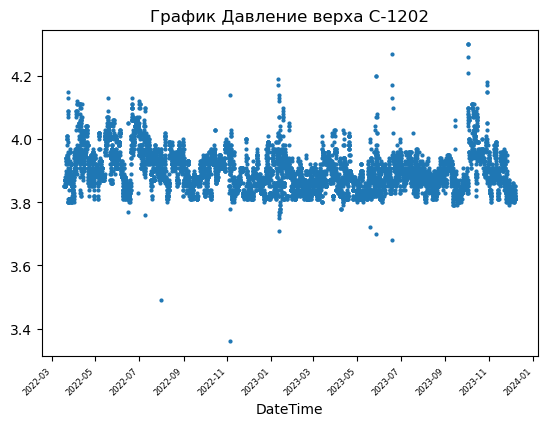

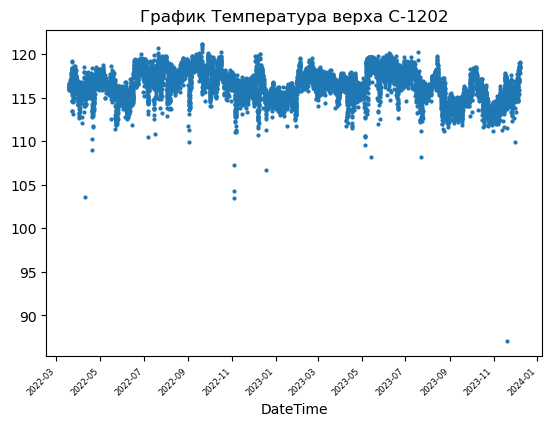

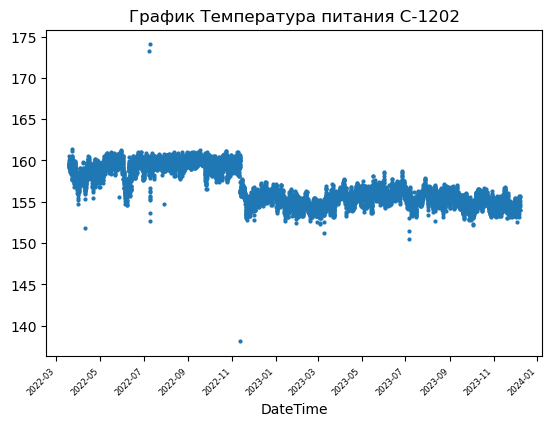

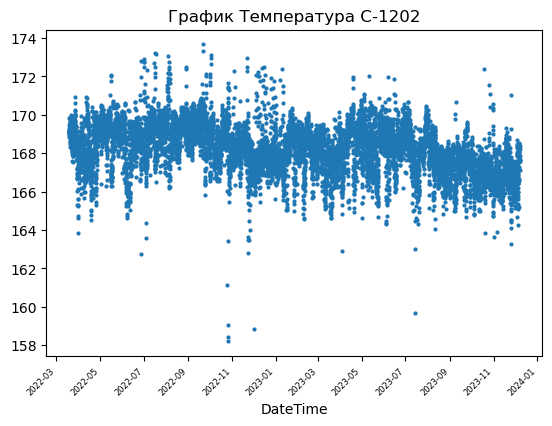

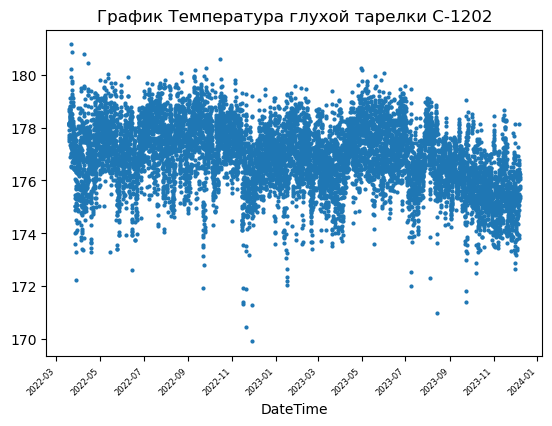

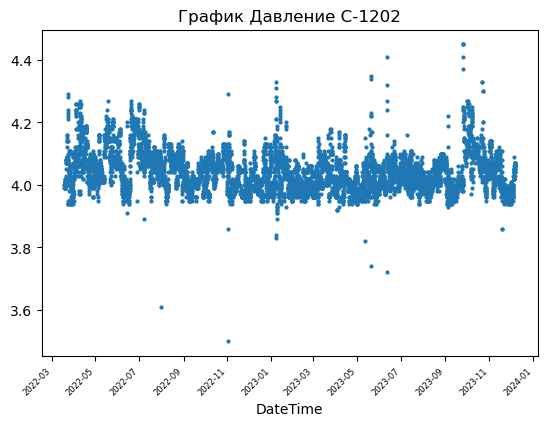

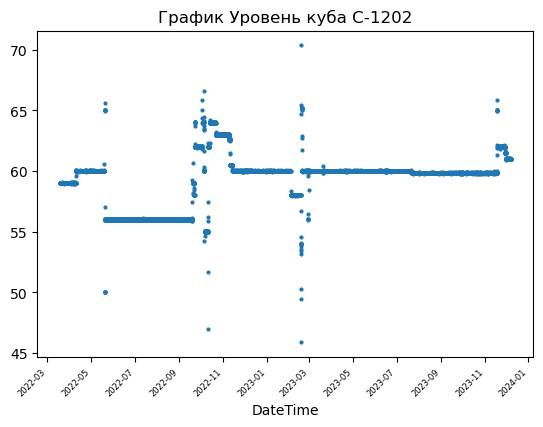

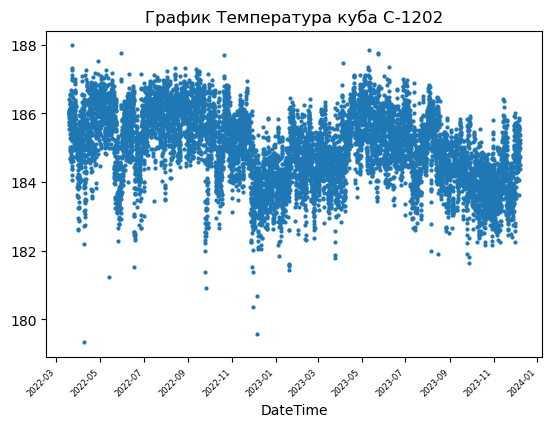

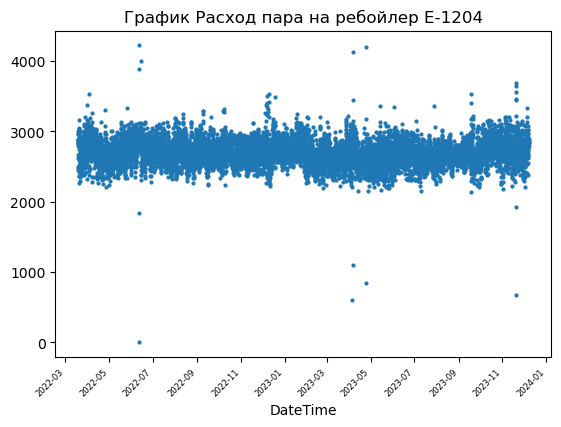

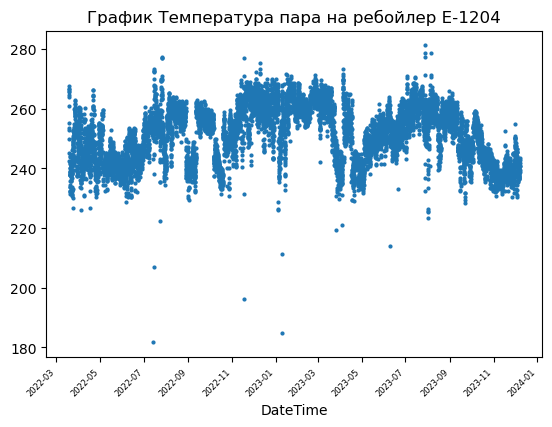

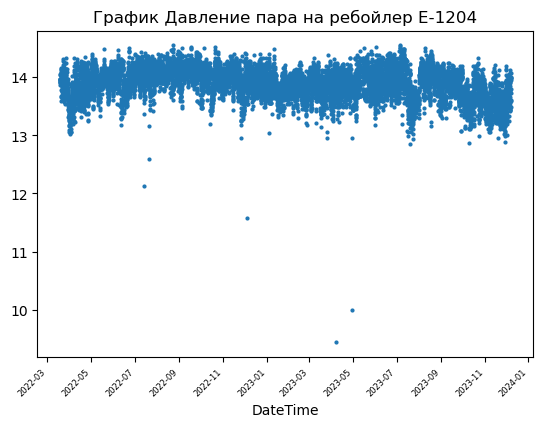

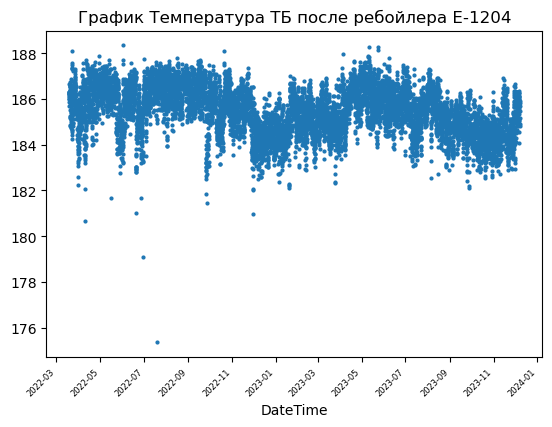

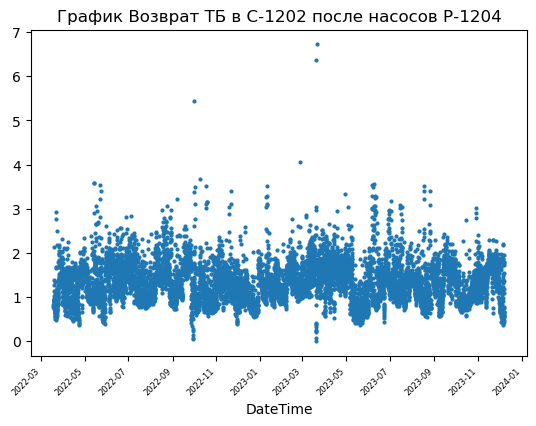

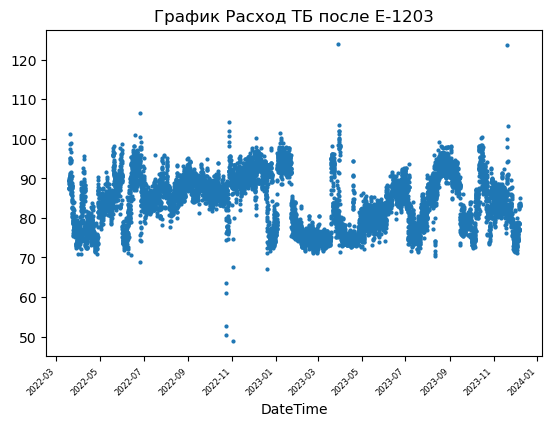

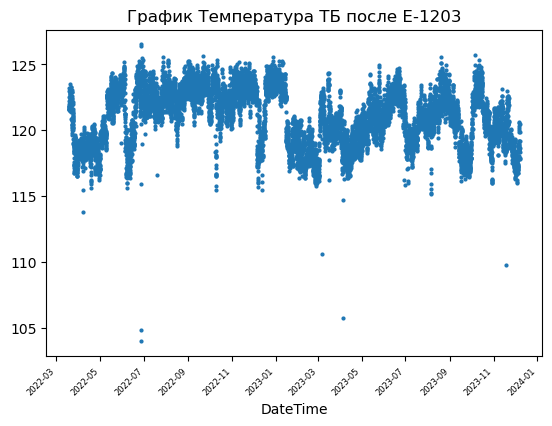

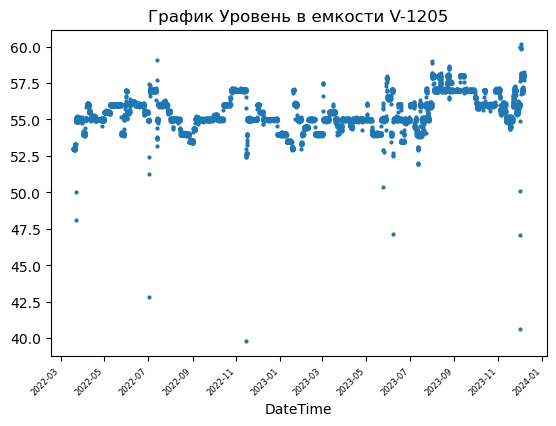

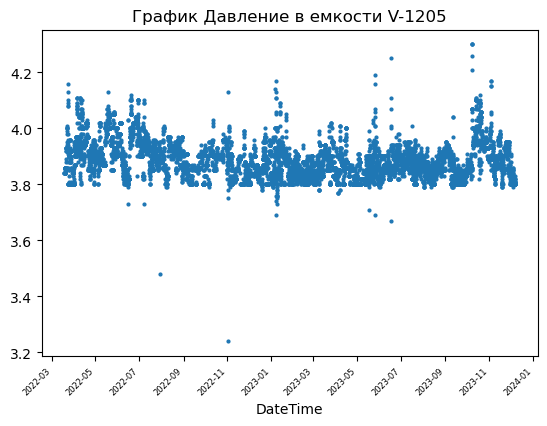

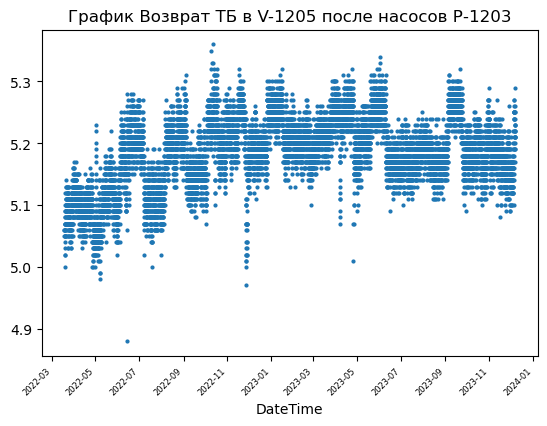

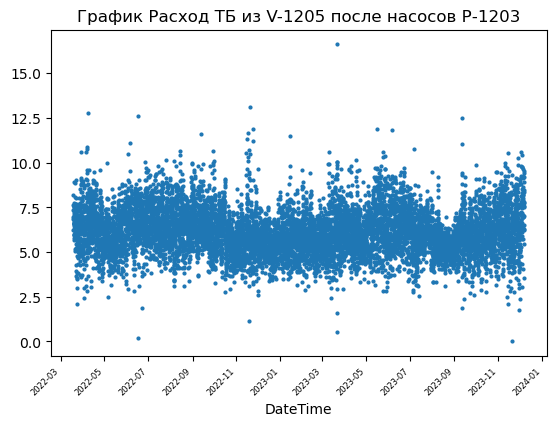

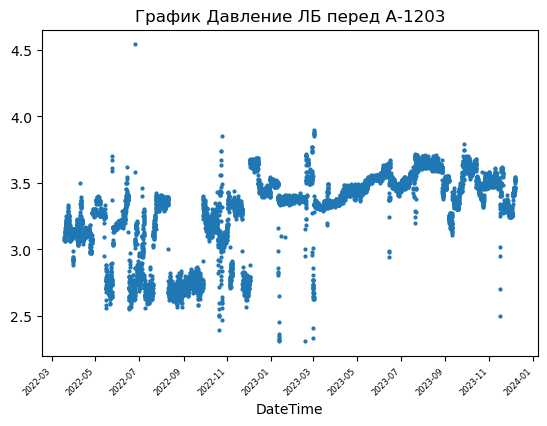

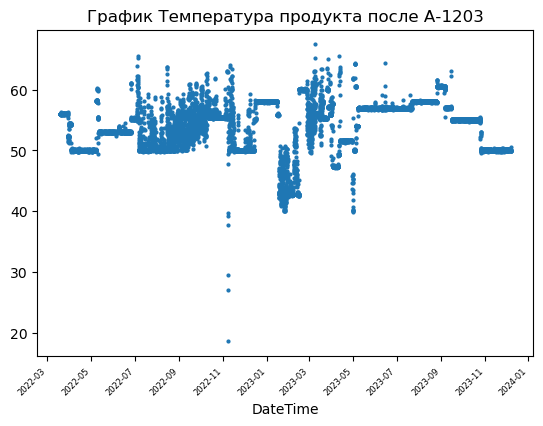

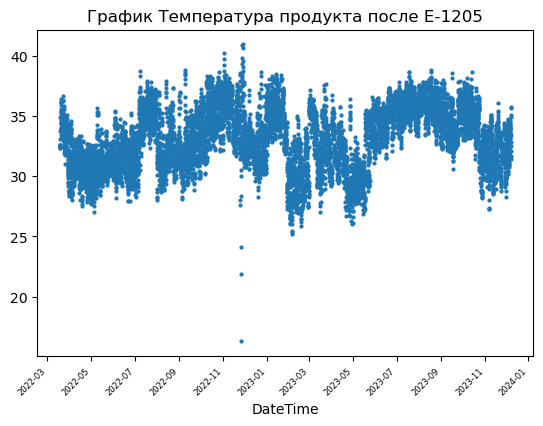

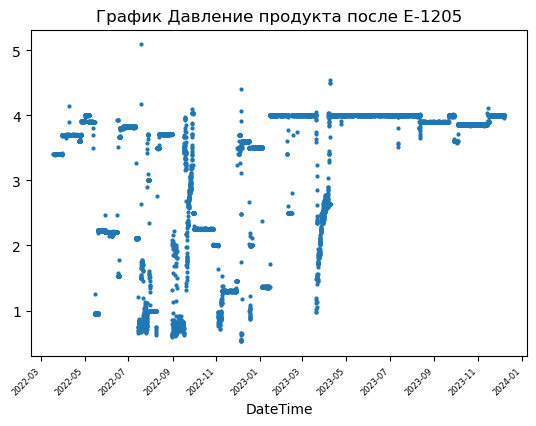

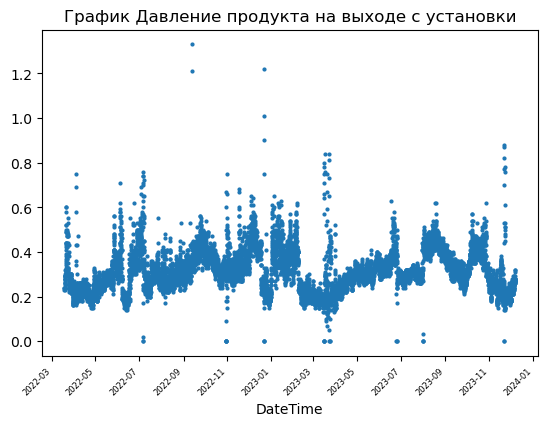

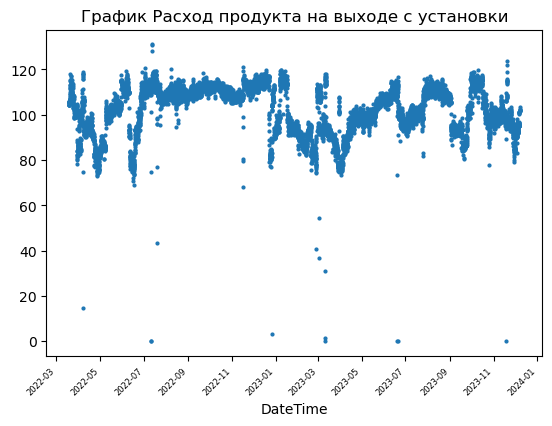

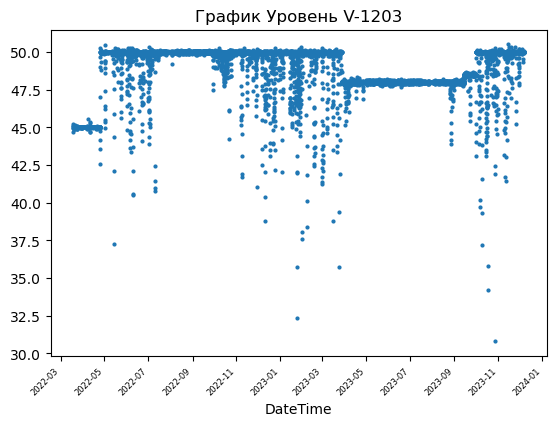

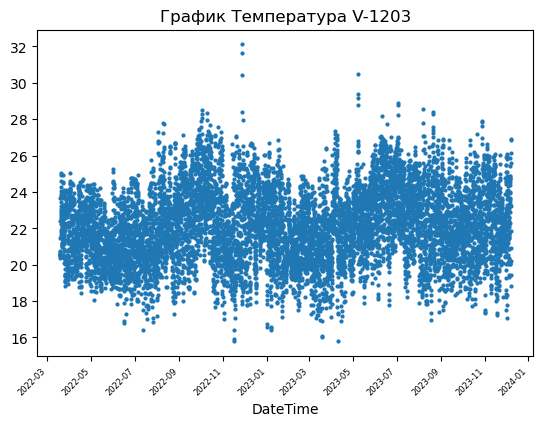

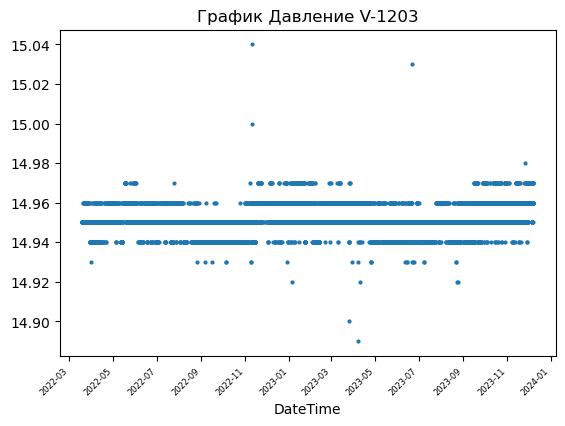

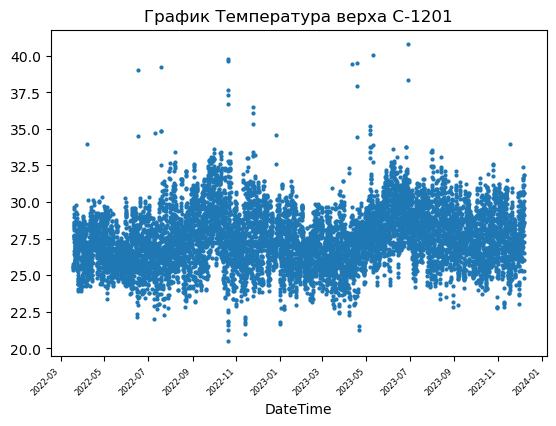

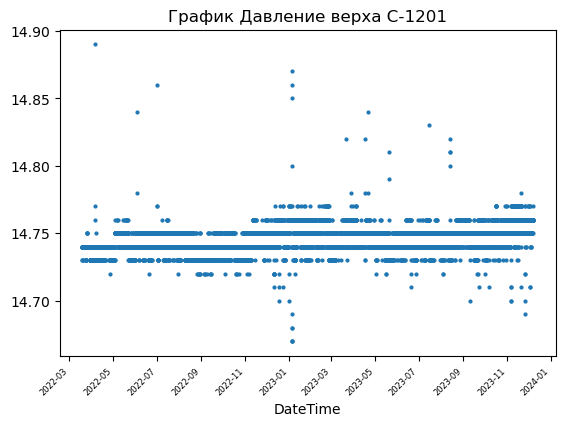

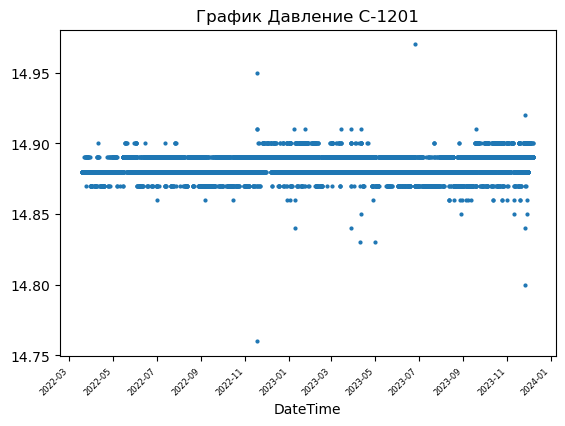

In [21]:
parameter_vis(filtered_df)